In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

# Data retrival and feature engineering

In [15]:
df = pd.read_csv("./data/grouped_irradiance/grouped_irradiance.csv", delim_whitespace=True, parse_dates=["Time"])

In [134]:
df = df.assign(eff_irradiance=(df.irr_dir * 0.9))
df = df.assign(month=df.Time.dt.month_name())
df.head()

,Time,irr_g,irr_dir,irr_diff,temp,city,eff_irradiance,heat_consumption,month
0,2010-01-01 00:00:00,0.0,0.0,0.0,-0.18,Zurich,0.0,53.813333,January
1,2010-01-01 01:00:00,0.0,0.0,0.0,-0.06,Zurich,0.0,53.493333,January
2,2010-01-01 02:00:00,0.0,0.0,0.0,0.06,Zurich,0.0,53.173333,January
3,2010-01-01 03:00:00,0.0,0.0,0.0,0.18,Zurich,0.0,52.853333,January
4,2010-01-01 04:00:00,0.0,0.0,0.0,0.07,Zurich,0.0,53.146667,January


In [111]:
W0 = 80.  # power at pos 0
W1 = 0.   # power at pos 1
T0 = -10. # Temp at pos 0
T1 = 20.  # Temp at pos 1
a = (W1 - W0)/(T1-T0)  # Linear relation coefficient
b = W0 - a*T0  # Linear relation coefficien

temp_serie = (df.temp* a + b - df.eff_irradiance)
temp_serie = temp_serie.apply(lambda x: x if x>0 else 0)
df = df.assign(heat_consumption=temp_serie)

Text(0.5, 0, '')

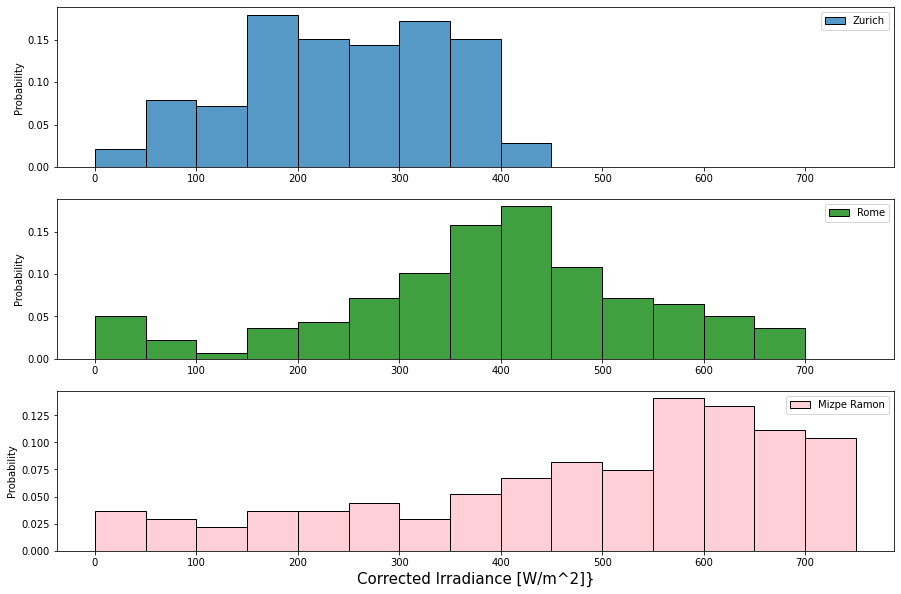

In [52]:
bins_irr = np.arange(0,800,50)
fig, ax = plt.subplots(3,1,figsize=(15,10))
sns.histplot(data=df[(df.eff_irradiance > 0)&(df.city =="Zurich")], x="eff_irradiance", stat="probability", ax=ax[0], bins=bins_irr)
sns.histplot(data=df[(df.eff_irradiance > 0)&(df.city =="Rome")], x="eff_irradiance", stat="probability", ax=ax[1], bins=bins_irr, color="green")
sns.histplot(data=df[(df.eff_irradiance > 0)&(df.city =="Mizpe")], x="eff_irradiance", stat="probability", ax=ax[2], bins=bins_irr, color="pink")
ax[2].set_xlabel("Corrected Irradiance [W/m^2]}", fontsize=15)
ax[0].legend(["Zurich"])
ax[1].legend(["Rome"])
ax[2].legend(["Mizpe Ramon"])
ax[0].set_xlabel("")
ax[1].set_xlabel("")

Text(0.5, 0, '')

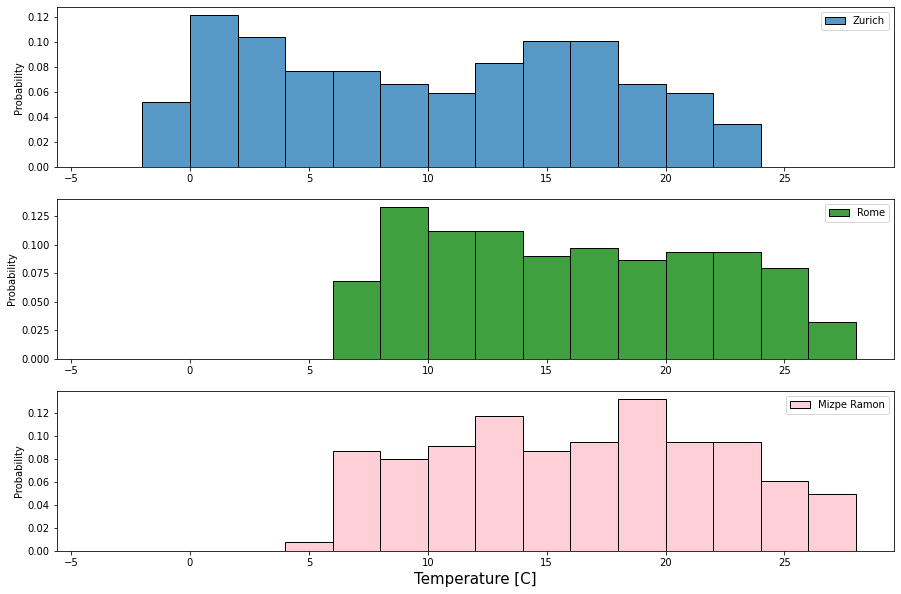

In [55]:
bins_temp = np.arange(-4,30,2)
fig, ax = plt.subplots(3,1,figsize=(15,10))
sns.histplot(data=df[(df.city =="Zurich")], x="temp", stat="probability", ax=ax[0], bins=bins_temp)
sns.histplot(data=df[(df.city =="Rome")], x="temp", stat="probability", ax=ax[1], bins=bins_temp, color="green")
sns.histplot(data=df[(df.city =="Mizpe")], x="temp", stat="probability", ax=ax[2], bins=bins_temp, color="pink")
ax[0].legend(["Zurich"])
ax[1].legend(["Rome"])
ax[2].legend(["Mizpe Ramon"])
ax[2].set_xlabel("Temperature [C]", fontsize=15)
ax[0].set_xlabel("")
ax[1].set_xlabel("")

# Seasonal Plots

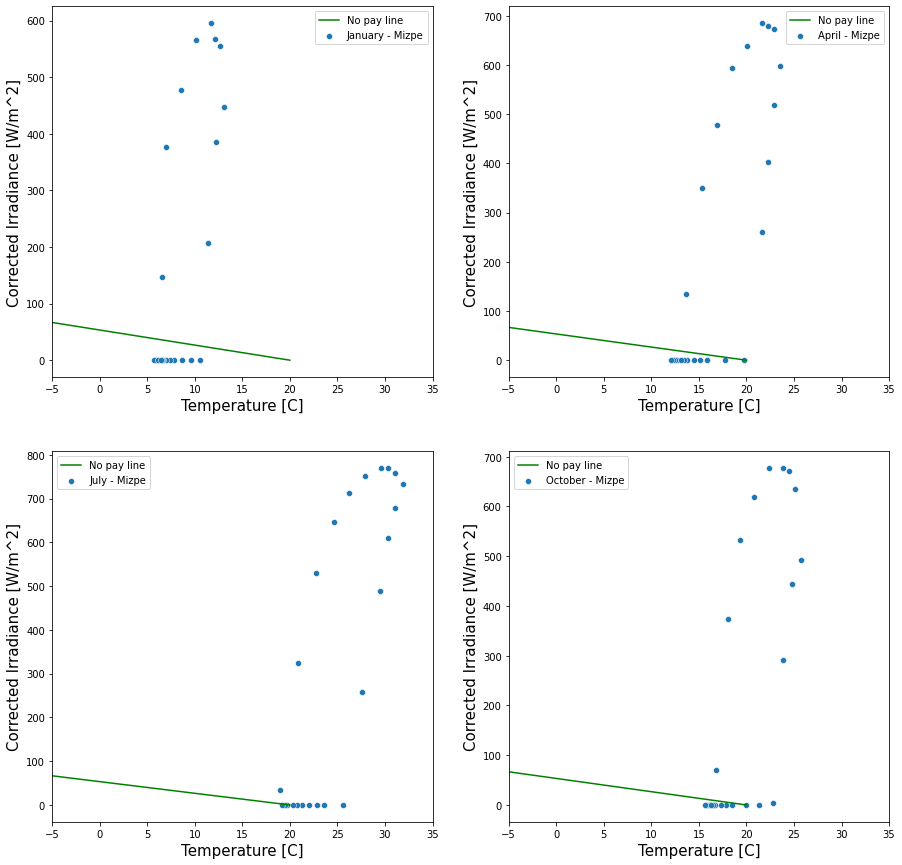

In [149]:
city = "Mizpe"

fig, ax = plt.subplots(2,2,figsize=(15,15))
sns.scatterplot(data=df[(df.Time.dt.month == 1)&(df.city == city)], y="eff_irradiance", x="temp", ax=ax[0,0])
sns.scatterplot(data=df[(df.Time.dt.month == 4)&(df.city == city)], y="eff_irradiance", x="temp", ax=ax[0,1])
sns.scatterplot(data=df[(df.Time.dt.month == 7)&(df.city == city)], y="eff_irradiance", x="temp", ax=ax[1,0])
sns.scatterplot(data=df[(df.Time.dt.month == 10)&(df.city == city)], y="eff_irradiance", x="temp", ax=ax[1,1])


ax = np.reshape(ax,4)

for a in ax:
    a.plot([-10,20],[80,0], color="green")
    a.set_xlim(-5,35)
    a.set_ylabel("Corrected Irradiance [W/m^2]", fontsize=15)
    a.set_xlabel("Temperature [C]",fontsize=15)

ax[0].legend(["No pay line",f"January - {city}"])
ax[1].legend(["No pay line",f"April - {city}"])
ax[3].legend(["No pay line",f"October - {city}"])
ax[2].legend(["No pay line",f"July - {city}"])


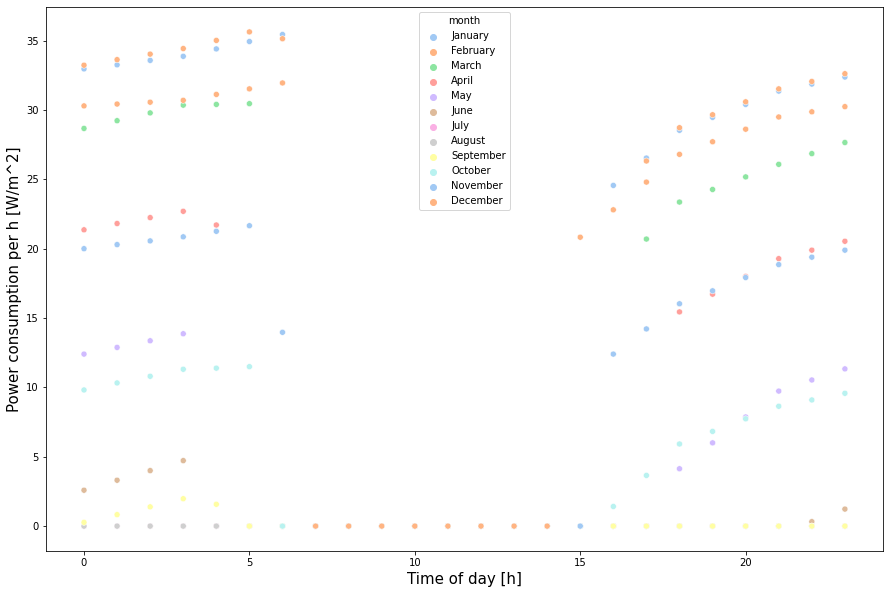

In [153]:
city = "Rome"
df_slice = df.loc[df.city == city]

fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x=df_slice.Time.dt.hour, 
                y=df_slice.heat_consumption, 
                hue=df_slice.month, 
                ax=ax, 
                palette="pastel",
                legend="full")

ax.set_xlabel("Time of day [h]", fontsize=15)
ax.set_ylabel("Power consumption per h [W/m^2]",fontsize=15)
plt.show()


In [154]:
print("Price per m^2 per year ",(df_slice.heat_consumption * 30).sum() /1000 * 0.1)

Price per m^2 per year  7.418754000000002
